In [1]:
import pandas as pd

#INCAR data from bbsr
#https://www.inkar.de
#Vor allem: Anteil Fertiggestellte Wohnungen / Wohngebäude mit erneuerbarer Heizenergie, 2017-2019

#convert pandas series from German number format (1.000,5) to python number format (1000.5)
def make_column_numeric(se):
    se = se.str.replace('.','',regex=True)
    se = se.str.replace(',','.',regex=True)
    se = pd.to_numeric(se)
    return se

#read dataset
df = pd.read_csv("data/inkar_heating.csv", delimiter=';', header=[0,1])
df.columns = df.columns.map('_'.join)

#rename unnamed headers
df.rename({"Kennziffer_Unnamed: 0_level_1": "Kennziffer","Raumeinheit_Unnamed: 1_level_1":"Raumeinheit","Aggregat_Unnamed: 2_level_1":"Aggregated"}, axis=1,inplace=True)

#calculate neubauwohnungen total and neubauwohnungen renewable total
years = ["2018","2019"]
for year in years:
    #make columns numerics
    neubau_einwohner = "Neubauwohnungen je Einwohner_" + str(year)
    einwohner = 'Bevölkerung gesamt_' + str(year)
    neubauwohnungen_renewable_anteil = "Fertiggestellte Wohnungen mit erneuerbarer Heizenergie_" + str(year)
    neubauwohngebäude_renewable_anteil = "Fertiggestellte Wohngebäude mit erneuerbarer Heizenergie_" + str(year)
    
    df[neubau_einwohner] = make_column_numeric(df[neubau_einwohner]) 
    df[einwohner] = make_column_numeric(df[einwohner]) 
    df[neubauwohnungen_renewable_anteil] = make_column_numeric(df[neubauwohnungen_renewable_anteil]) / 100
    df[neubauwohngebäude_renewable_anteil] = make_column_numeric(df[neubauwohngebäude_renewable_anteil]) / 100

    #Neubauwohnungen = Neubauwohnungen je Einwohner * Einwohner 
    neubau = "neubauwohnungen_" + str(year)
    df[neubau] = df[neubau_einwohner] *  df[einwohner]

    #Neubauwohnungen renewable = Neubauwognungen * Anteil Renewalbe
    #Wohnungen vs. Wohngebäude: aus Dokumentation: "Im Gegensatz zum Indikator Fertiggestellte Wohngebäude mit erneuerbarer Heizenergie werden hier 
    #Errichtungen von Wohnungen in Mehrfamilienhäusern gegenüber Ein- und Zweifamilienhäuser stärker gewichtet." Bei Wohngebäuden wäre ein Mehrfamilienhaus
    #genausoviel wert wie ein Einfamilienhaus
    neubauwohnungen_renewable =  "neubauwohnungen_erneuerbareheiz_" + str(year)
    df[neubauwohnungen_renewable] = df[neubau] *  df[neubauwohnungen_renewable_anteil]

    neubauwohngebäude_renewable =  "neubauwohngebäude_erneuerbareheiz_" + str(year)
    df[neubauwohngebäude_renewable] = df[neubau] *  df[neubauwohngebäude_renewable_anteil]

df.to_csv("data/inkar_heating_output.csv")


In [3]:
#https://www-genesis.destatis.de/genesis/online#astructure
#Baufertigstellungen neuer Gebäude: Deutschland, Jahre, Gebäudeart, Energieverwendung, Energieart
#von 2014 - 2021, auf Deutschlandebene

import plotly.graph_objects as go
import plotly_express as px
import numpy as np


def preprocess_dataset_germany_by_building_type(df,building_type):

    #Nur den Typ des Gebäudes auswählen
    df = df.loc[df["2_Auspraegung_Label"] == building_type]

    #Nur Zum Heizen verwendete Primärenergie
    df = df.loc[df2["3_Auspraegung_Code"] == "ENR-HZG-PRM-01"]

    df.rename({"Zeit": "year","BAU005__Neue_Gebaeude__Anzahl":"buildings","4_Auspraegung_Label":"energy"}, axis=1,inplace=True)

    #make building number numeric
    df["buildings"] = df["buildings"].replace({'-':'0',".":"0"})
    df["buildings"] = pd.to_numeric(df["buildings"])

    return df

def plot_heating(viz,asProportion = True,useWohnungen = True):

    """
        Parameters
        ----------
        viz : df
            dataframe slice of your data, for example a specific landkreis
        asProportion : bool, optional
            if true, the visualisation will use proportion. otherwise, the total number is used. default is true
        useWohnungen : bool, optional
            if true, flats will be counted. otherwise, buildings will be counted (which maybe have multiple flats in them). default is true
    """

    viz.rename({"Zeit": "year","BAU017__Wohngebaeude_insgesamt__Anzahl":"buildings","Heizenergie_Auspraegung_Label":"energy",
        "Wohngebäude_Anteil":"buildings_anteil","Wohnungen_Anteil":"flats_anteil",
        "WOHN04__Wohnungen_in_Wohngebaeuden_(ohne_Wohnheime)__Anzahl":"flats"}, axis=1,inplace=True)

    # dont add gesamtenergie to plot
    viz = viz[viz["energy"] != "Wohngebäude Insgesamt"]
    viz = viz[viz["energy"] != "Wohnungen Insgesamt"]
    viz = viz[viz["energy"] != "Insgesamt"]
    
    obj = "Anzahl"

    if useWohnungen:
        column="flats"
        name = "Wohnungen in Wohngebäuden"

        #for wohnungen: do not differ between 1, 2 or 3 or more flats
        viz= viz[viz["Wohnort_Auspraegung_Label"] == "Wohnungen Insgesamt"]
    
    else:
        column='buildings'
        name = "Wohngebäude"

        viz= viz[viz["Wohnort_Auspraegung_Label"] == "Wohngebäude Insgesamt"]
    
    if asProportion:
        column += "_anteil"
        obj = "Anteile"

    #pivot data
    pivot = pd.pivot_table(viz, index='year',columns='energy', values=column)
    pivot = pivot.reset_index(level=0)

    pivot["ort_ags"] = str(viz["Ort_Auspraegung_Code"].iloc[0])
    pivot["ort_name"]= str(viz["Ort_Auspraegung_Label"].iloc[0])

    #add bar per energy
    energies = viz["energy"].unique()

    print(energies);
    data = []
    for energy in energies:
        data.append(go.Bar(name=energy, x=pivot["year"], y=pivot[energy]))

    #plot bar chart
    fig = go.Figure(data = data)
    fig.update_layout(barmode='stack',title= obj + " von Energiesystemen in fertiggestellten " + name +" in " + str(viz["Ort_Auspraegung_Label"].iloc[0]))
    fig.show()

    #plot line chart
    fig2 = go.Figure()
    colors = px.colors.qualitative.Plotly

    for i,energy in enumerate(energies):
        fig2.add_traces(go.Scatter(x=pivot['year'], y = pivot[energy], mode = 'lines', line=dict(color=colors[i%10]),name=energy))
    
    fig2.show()

def move_to_third_section(df,title,value):
    second_section = "2_" + title;
    third_section = "3_" + title;

    if "Merkmal" in title:
        df[third_section] = np.where((df[second_section] == value), df[second_section],df[third_section])
        #df[second_section] = np.where((df[second_section] == value),"WOHNGEBAUDE GESAMT",df[third_section])

    elif "Auspraegung" in title:
        merkmal = second_section.replace("Auspraegung","Merkmal")
        df[third_section] = np.where((df[merkmal] == value), df[second_section],df[third_section])
        #df[second_section] = np.where((df[merkmal] == value),"WOHNGEBAUDE GESAMT",df[third_section])

    else:
        print("unknown title: ", title)

    return df


def preprocess_dataset_kreise(df):

    #AGS Germany ist jetzt 0
    df["1_Auspraegung_Code"] = df["1_Auspraegung_Code"].replace({"DG":"0"})    
    df["1_Auspraegung_Code"] = pd.to_numeric(df["1_Auspraegung_Code"])

    #clean up multi level format of raw data 
    df["2_Auspraegung_Label"] = df["2_Auspraegung_Label"].replace({"Insgesamt":'Wohnungen Insgesamt'})  
    #df["2_Auspraegung_Label"] = df["2_Auspraegung_Label"].str.replace('Insgesamt','Wohnungen Insgesamt',regex=True)
    df.loc[df["2_Auspraegung_Code"] == "INSGESAMT","2_Auspraegung_Label"] = "Wohngebäude Insgesamt"

    titles = ["Merkmal_Code","Merkmal_Label","Auspraegung_Code","Auspraegung_Label"]

    for title in titles:
        if "Code" in title:
            df = move_to_third_section(df,title,"BAUPHE")
        elif "Label" in title:
            df = move_to_third_section(df,title,"Primär verwendete Heizenergie")

    for title in reversed(titles):
        title = "2_" + title
        df[title] = np.where((df["2_Merkmal_Code"] == "BAUPHE"),"Wohngebäude Insgesamt",df[title])

    #rename columns
    df.columns = df.columns.str.replace("1_", "Ort_")
    df.columns = df.columns.str.replace("2_", "Wohnort_")
    df.columns = df.columns.str.replace("3_", "Heizenergie_")


    #make building counts numeric
    building_counts = ["BAU017__Wohngebaeude_insgesamt__Anzahl","WOHN04__Wohnungen_in_Wohngebaeuden_(ohne_Wohnheime)__Anzahl","BAU018__Nichtwohngebaeude_insgesamt__Anzahl"]
    
    for building in building_counts:
        df[building] = df[building].str.replace('-','0',regex=True)
        df[building].fillna(0,inplace=True)
        df[building] = pd.to_numeric(df[building])


    #set total number of buildings for each year and place
    years = list(range(2016, 2021))
    orte = df["Ort_Auspraegung_Code"].unique()

    for ort in orte:
        for year in years:
            isLocation = (df["Ort_Auspraegung_Code"] == ort)
            isYear = (df["Zeit"] == year)

            gesamt = df.loc[isLocation & isYear & (df["Heizenergie_Auspraegung_Code"] == "INSGESAMT")].copy()
            
            gesamt_wohngebaeude = gesamt.loc[(gesamt["Wohnort_Auspraegung_Label"] == "Wohngebäude Insgesamt"),"BAU017__Wohngebaeude_insgesamt__Anzahl"]
            gesamt_wohnungen = gesamt.loc[(gesamt["Wohnort_Auspraegung_Label"] == "Wohnungen Insgesamt"),"WOHN04__Wohnungen_in_Wohngebaeuden_(ohne_Wohnheime)__Anzahl"]

            if(gesamt_wohngebaeude.size == 1 and gesamt_wohnungen.size == 1):
                df.loc[isLocation & isYear,"Wohngebäude_Gesamt"] = int(gesamt_wohngebaeude.item())
                df.loc[isLocation & isYear,"Wohnungen_Gesamt"] = int(gesamt_wohnungen.item())
            else:
                print("error: gesamt is wrong",gesamt)

    #calculate proportions
    df["Wohngebäude_Anteil"] = df["BAU017__Wohngebaeude_insgesamt__Anzahl"] / df["Wohngebäude_Gesamt"] * 100
    df["Wohnungen_Anteil"] = df["WOHN04__Wohnungen_in_Wohngebaeuden_(ohne_Wohnheime)__Anzahl"] / df["Wohnungen_Gesamt"] * 100


    #Drop unneccessary columns to save space
    df.drop(['Statistik_Label','Ort_Merkmal_Label'], axis=1, inplace = True)


    return df

def create_pivot_tables(df_p,asProportion = True,useWohnungen = True):

    df = df_p.copy()
    
    df.rename({"Zeit": "year","BAU017__Wohngebaeude_insgesamt__Anzahl":"buildings","Heizenergie_Auspraegung_Label":"energy",
        "Wohngebäude_Anteil":"buildings_anteil","Wohnungen_Anteil":"flats_anteil",
        "WOHN04__Wohnungen_in_Wohngebaeuden_(ohne_Wohnheime)__Anzahl":"flats"}, axis=1,inplace=True)

    # dont add gesamtenergie to plot
    df = df[df["energy"] != "Wohngebäude Insgesamt"]
    df = df[df["energy"] != "Wohnungen Insgesamt"]
    df = df[df["energy"] != "Insgesamt"]


    if useWohnungen:
        column="flats"
        
        #for wohnungen: do not differ between 1, 2 or 3 or more flats
        df= df[df["Wohnort_Auspraegung_Label"] == "Wohnungen Insgesamt"]
    
    else:
        column='buildings'
        df= df[df["Wohnort_Auspraegung_Label"] == "Wohngebäude Insgesamt"]
    
    if asProportion:
        column += "_anteil"

    #pivot data
    orte = df["Ort_Auspraegung_Code"].unique()

    pivot_total = pd.DataFrame()

    for ort in orte:
        snippet = df[df["Ort_Auspraegung_Code"] == ort]

        temp = pd.pivot_table(snippet, index='year',columns='energy', values=column)
        temp = temp.reset_index(level=0)

        temp["ort_ags"] = ort
        temp["ort_name"]= str(snippet["Ort_Auspraegung_Label"].iloc[0])

        pivot_total = pd.concat([pivot_total, temp])

    #sum up renewables and fossils
    renewables = ["Solarthermie","Geothermie","Umweltthermie (Luft/Wasser)","Holz","Biogas/Biomethan","Sonstige Biomasse","Keine Energie (einschl. Passivhaus)"]
    fossils = ["Gas","Strom","Öl","Fernwärme/Fernkälte","Sonstige Heizenergie"]

    pivot_total["renewables"] = pivot_total[renewables].sum(axis=1)
    pivot_total["fossils"] = pivot_total[fossils].sum(axis=1)


    
    pivot_total.to_csv("data/newbuildings_pivot_"+column+".csv")
    return pivot_total


In [4]:
#https://www.regionalstatistik.de/genesis/online?operation=previous&levelindex=3&step=2&titel=Tabellenaufbau&levelid=1655207886087&levelid=1655207857464#abreadcrumb
#Fertigstellungen neuer Wohngebäude und Nichtwohngebäude sowie Wohnungen in Wohngebäuden nach Zahl der Wohnungen und vorwiegender Art der Beheizung - Jahressumme
# no need to run this

df_kreise_org = pd.read_csv("data/newbuildings_kreise.csv",delimiter=";", encoding='latin1')
df_kreise = df_kreise_org.copy()


df_kreise = preprocess_dataset_kreise(df_kreise)
df_kreise.to_csv("data/newbuildings_kreise_output.csv")
df_kreise


/var/folders/6w/mz49x3ds0b18vg8p9jx7wg0r0000gn/T/ipykernel_3234/2825758408.py:5: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_kreise_org = pd.read_csv("data/newbuildings_kreise.csv",delimiter=";", encoding='latin1')


,Statistik_Code,Zeit_Code,Zeit_Label,Zeit,Ort_Merkmal_Code,Ort_Auspraegung_Code,Ort_Auspraegung_Label,Wohnort_Merkmal_Code,Wohnort_Merkmal_Label,Wohnort_Auspraegung_Code,...,Heizenergie_Merkmal_Label,Heizenergie_Auspraegung_Code,Heizenergie_Auspraegung_Label,BAU017__Wohngebaeude_insgesamt__Anzahl,WOHN04__Wohnungen_in_Wohngebaeuden_(ohne_Wohnheime)__Anzahl,BAU018__Nichtwohngebaeude_insgesamt__Anzahl,Wohngebäude_Gesamt,Wohnungen_Gesamt,Wohngebäude_Anteil,Wohnungen_Anteil
0,31121,JAHR,Jahr,2020,KREISE,0,Deutschland,Wohngebäude Insgesamt,Wohngebäude Insgesamt,Wohngebäude Insgesamt,...,Primär verwendete Heizenergie,BAUPHE00,Keine Energie (einschl. Passivhaus),111,0,12960,112935.0,261124.0,0.098287,0.000000
1,31121,JAHR,Jahr,2020,KREISE,0,Deutschland,Wohngebäude Insgesamt,Wohngebäude Insgesamt,Wohngebäude Insgesamt,...,Primär verwendete Heizenergie,BAUPHE02,Öl,776,0,272,112935.0,261124.0,0.687121,0.000000
2,31121,JAHR,Jahr,2020,KREISE,0,Deutschland,Wohngebäude Insgesamt,Wohngebäude Insgesamt,Wohngebäude Insgesamt,...,Primär verwendete Heizenergie,BAUPHE03,Gas,44037,0,5014,112935.0,261124.0,38.993226,0.000000
3,31121,JAHR,Jahr,2020,KREISE,0,Deutschland,Wohngebäude Insgesamt,Wohngebäude Insgesamt,Wohngebäude Insgesamt,...,Primär verwendete Heizenergie,BAUPHE04,Strom,1606,0,780,112935.0,261124.0,1.422057,0.000000
4,31121,JAHR,Jahr,2020,KREISE,0,Deutschland,Wohngebäude Insgesamt,Wohngebäude Insgesamt,Wohngebäude Insgesamt,...,Primär verwendete Heizenergie,BAUPHE05,Fernwärme/Fernkälte,9053,0,1648,112935.0,261124.0,8.016115,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174845,31121,JAHR,Jahr,2016,KREISE,16077,"Altenburger Land, Kreis",GEBWH1,Gebäude nach Anzahl der Wohnungen,WHGZHL03UM,...,Primär verwendete Heizenergie,BAUPHE09,Holz,0,0,0,58.0,101.0,0.000000,0.000000
174846,31121,JAHR,Jahr,2016,KREISE,16077,"Altenburger Land, Kreis",GEBWH1,Gebäude nach Anzahl der Wohnungen,WHGZHL03UM,...,Primär verwendete Heizenergie,BAUPHE10,Biogas/Biomethan,0,0,0,58.0,101.0,0.000000,0.000000
174847,31121,JAHR,Jahr,2016,KREISE,16077,"Altenburger Land, Kreis",GEBWH1,Gebäude nach Anzahl der Wohnungen,WHGZHL03UM,...,Primär verwendete Heizenergie,BAUPHE11,Sonstige Biomasse,0,0,0,58.0,101.0,0.000000,0.000000
174848,31121,JAHR,Jahr,2016,KREISE,16077,"Altenburger Land, Kreis",GEBWH1,Gebäude nach Anzahl der Wohnungen,WHGZHL03UM,...,Primär verwendete Heizenergie,BAUPHE12,Sonstige Heizenergie,0,0,0,58.0,101.0,0.000000,0.000000


In [5]:
df_kreise = pd.read_csv("data/newbuildings_kreise_output.csv")

# create_pivot_tables_
#         viz : df dataframe slice of your data, for example a specific landkreis
#        asProportion : bool, optional
#            if true, the visualisation will use proportion. otherwise, the total number is used. default is true
#        useWohnungen : bool, optional
#            if true, flats will be counted. otherwise, buildings will be counted (which maybe have multiple flats in them). default is true
pivot = create_pivot_tables(df_kreise,False,True)
pivot

energy,year,Biogas/Biomethan,Fernwärme/Fernkälte,Gas,Geothermie,Holz,Keine Energie (einschl. Passivhaus),Solarthermie,Sonstige Biomasse,Sonstige Heizenergie,Strom,Umweltthermie (Luft/Wasser),Öl,ort_ags,ort_name,renewables,fossils
0,2016,919,42350,110439,12661,11690,123,1094,1135,911,1310,37200,1619,0,Deutschland,64822,156629
1,2017,1025,43993,105864,12543,13210,133,1127,1152,821,1243,46018,1660,0,Deutschland,75208,153581
2,2018,693,50748,98898,13934,14300,192,1488,829,1686,1569,52501,1479,0,Deutschland,83937,154380
3,2019,963,55745,98586,14778,12562,174,1157,857,1352,1841,56646,1502,0,Deutschland,87137,159026
4,2020,1104,60312,98726,15368,12026,129,1077,1084,1041,2424,66481,1352,0,Deutschland,97269,163855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2016,0,3,77,6,0,0,1,1,0,0,13,0,16077,"Altenburger Land, Kreis",21,80
1,2017,0,3,31,6,4,0,2,1,0,0,21,0,16077,"Altenburger Land, Kreis",34,34
2,2018,0,5,26,9,2,0,0,0,0,6,24,0,16077,"Altenburger Land, Kreis",35,37
3,2019,0,110,24,3,1,0,1,0,0,1,17,1,16077,"Altenburger Land, Kreis",22,136


['Keine Energie (einschl. Passivhaus)' 'Öl' 'Gas' 'Strom'
 'Fernwärme/Fernkälte' 'Geothermie' 'Umweltthermie (Luft/Wasser)'
 'Solarthermie' 'Holz' 'Biogas/Biomethan' 'Sonstige Biomasse'
 'Sonstige Heizenergie']


/var/folders/6w/mz49x3ds0b18vg8p9jx7wg0r0000gn/T/ipykernel_68379/2023176391.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



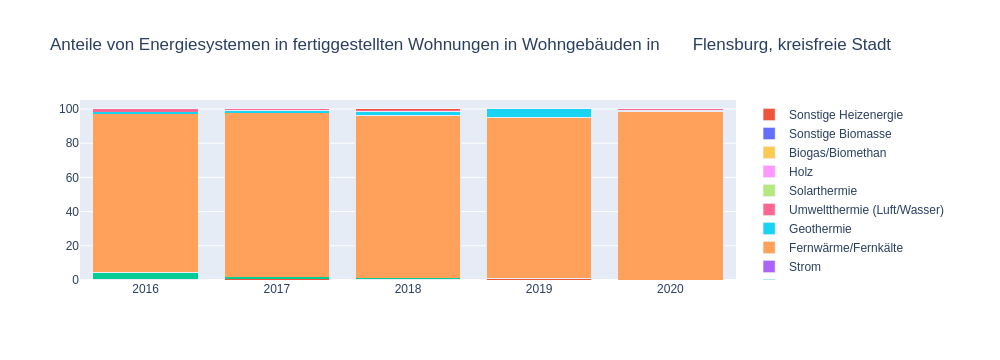

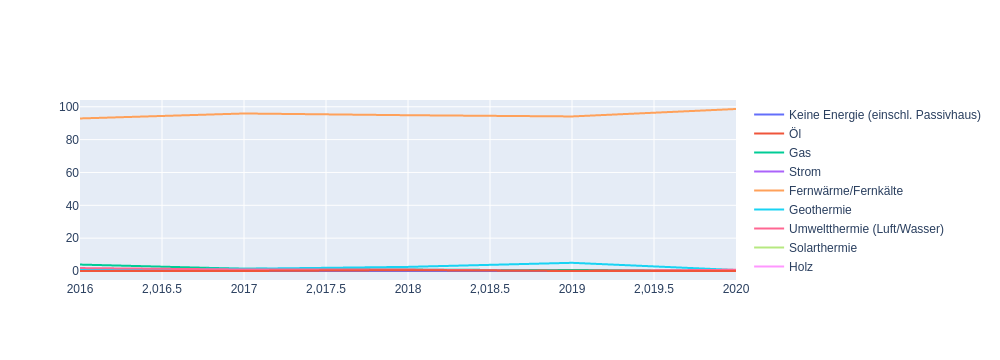

In [64]:
####

# here, you can plot the data for each landkreis.
# parameters:
# viz : df dataframe slice of your data, for example a specific landkreis
# asProportion : bool, optional
#       if true, the visualisation will use proportion. otherwise, the total number is used. default is true
# useWohnungen : bool, optional
#       if true, flats will be counted. otherwise, buildings will be counted (which maybe have multiple flats in them). default is true

####
df_kreise = pd.read_csv("data/newbuildings_kreise_output.csv")

plot_heating(df_kreise[df_kreise["Ort_Auspraegung_Code"] == 1001],True,True)


['Keine Energie (einschl. Passivhaus)' 'Öl' 'Gas' 'Strom'
 'Fernwärme/Fernkälte' 'Geothermie' 'Umweltthermie (Luft/Wasser)'
 'Solarthermie' 'Holz' 'Biogas/Biomethan' 'Sonstige Biomasse'
 'Sonstige Heizenergie']


/var/folders/6w/mz49x3ds0b18vg8p9jx7wg0r0000gn/T/ipykernel_3234/3386166944.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viz.rename({"Zeit": "year","BAU017__Wohngebaeude_insgesamt__Anzahl":"buildings","Heizenergie_Auspraegung_Label":"energy",


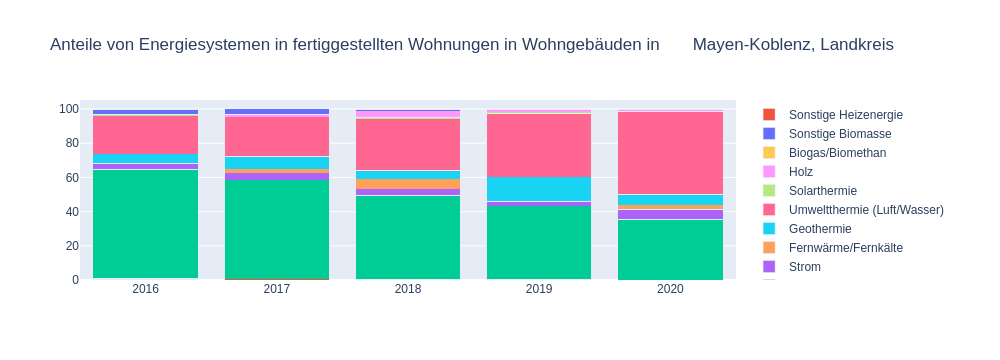

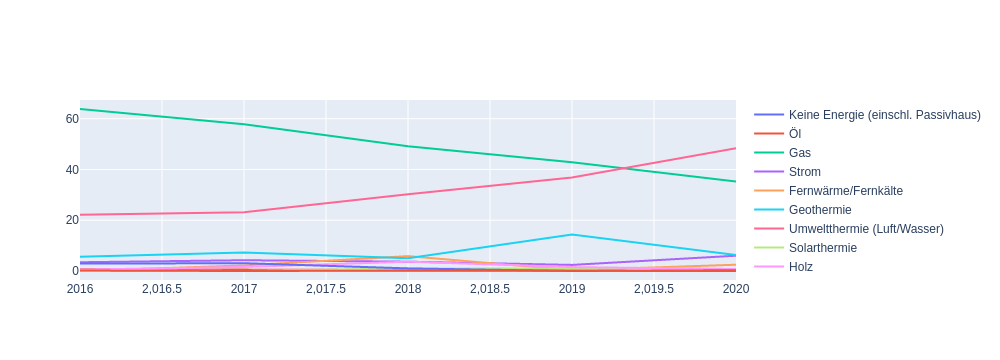

year,energy,2016,2017,2018,2019,2020
0,Biogas/Biomethan,0.000000,0.000000,0.000000,0.000000,0.000000
1,Fernwärme/Fernkälte,0.000000,2.196193,5.865103,0.343053,2.472952
2,Gas,63.818182,57.833089,49.120235,42.881647,35.239567
3,Geothermie,5.636364,7.320644,4.985337,14.408233,6.336940
4,Holz,0.545455,1.610542,3.665689,1.543739,0.772798
5,Insgesamt,100.000000,100.000000,100.000000,100.000000,100.000000
6,Keine Energie (einschl. Passivhaus),0.181818,0.000000,0.000000,0.171527,0.000000
7,Solarthermie,0.363636,0.000000,1.026393,1.029160,0.463679
8,Sonstige Biomasse,2.909091,3.074671,1.026393,0.000000,0.309119
9,Sonstige Heizenergie,0.181818,0.000000,0.146628,0.171527,0.000000


In [8]:
#plot_heating_timeseries(df_kreise[df_kreise["Ort_Auspraegung_Code"] == 1001],False,True)
# Preparation of Workshop : extract data for "Mayen-Koblenz"

mk = df_kreise[df_kreise["Ort_Auspraegung_Code"] == 7137]
mk.to_csv("mayenkoblenz2.csv")

plot_heating(mk,True,True)


mk = mk[mk["Wohnort_Auspraegung_Label"] == "Wohnungen Insgesamt"]
#pivot data
pivot = mk.pivot_table(index='energy',columns='year', values="flats_anteil")
pivot = pivot.reset_index(level=0)

#pivot.to_csv("mayenkoblenz_reshpe.csv")
#df_kreise
pivot

In [ ]:

##choose on of those labels
#print("Auswahl an Wohngebäuden:")
#print(df2_org["2_Auspraegung_Label"].unique())

#dataset all of germany
df2_org = pd.read_csv("data/newbuildings_germany.csv",delimiter=";", encoding='latin1')
df2 = df2_org.copy();

df2_viz = preprocess_dataset_germany_by_building_type(df2,"Wohngebäude")

#ploz
plot_heating_timeseries(df2_viz)
